# 02 Keras - the sequential model

Implementing a neural network in pure theano is, let us be honest, far from trivial, especially if you're not a computer scientist with a decent background in math and calculus. Building your on networks from scratch therefore tends to be time-consuming and error-prone. Luckily there are a number of excellent libraries, such as **Keras**, a highly popular and user-friendly Deep Learning library, that functions as a wrapper around Theano or TensorFlow, which it uses as its **backend**. In this chapter, we will learn how to set up a basic experiment in keras, using its **Sequential** model. We set up our environment:

In [99]:
from __future__ import print_function

## The (Multilayer) Perceptron

Let us start off with an easy task and build a (multi-layer) perceptron that is optimized to perform topic classification on text documents: we will build a neural network on top of a simple bag-of-words model. I provided some training from the 20 newsgroups data set:

In [100]:
import os, codecs

path = 'data/newsgroups/'
for dir_name in os.listdir(path):
    if os.path.isdir(path+dir_name):
        cnt = 0
        for fn in os.listdir(path+dir_name):
            cnt += 1
        print(dir_name, '->', cnt, 'files')

alt.atheism -> 1000 files
rec.autos -> 1000 files
rec.sport.baseball -> 1000 files
sci.med -> 1000 files
talk.politics.mideast -> 1000 files


As you can see, we have ca. 5000 documents distributed over five topical categories, raning from cars to politics. Learning a document classifier on this data should be fairly straightforward, because of the huge thematic differences we can expect in the texts' vocabularies. We can read in the documents and labels as follows:

In [101]:
documents, labels = [], []
for dir_name in os.listdir(path):
    if os.path.isdir(path+dir_name):
        cnt = 0
        for fn in os.listdir(path+dir_name):
            with codecs.open(path+dir_name+'/'+fn, 'r', 'utf8') as f:
                try:
                    text = f.read()
                    documents.append(text)
                    labels.append(dir_name)
                except UnicodeDecodeError:
                    pass

print('# documents:', len(documents))
print('# labels:', len(labels))

# documents: 4979
# labels: 4979


As you can see, encoding issues prevented us from loading a couple of files, but that's OK for this dummy case study. The variable `documents` now holds a list of strings: to convert these into a standard bag-of-words model, we can use the efficient `TfidfVectorizer` from `sklearn`:

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

Let us fit and apply the vectorizer to our documents, but let's not use TF-IDF rescoring or remove stop words (in order not to make the problem too easy either).

In [103]:
vectorizer = TfidfVectorizer(max_features=5000, analyzer='word', use_idf=False)
X = vectorizer.fit_transform(documents).toarray()
print(X.shape)

(4979, 5000)


We obtain a 4979 by 5000 matrix: 4979 row vectors in which each documented is characterized by 5000 relative word frequencies. Let us have a look at some of the vocabulary items included:

In [104]:
print(vectorizer.get_feature_names()[1000:1100])

[u'clarku', u'clas', u'class', u'classic', u'clean', u'cleaning', u'cleansing', u'clear', u'clearly', u'clemens', u'cleveland', u'clinic', u'clinical', u'clinton', u'clock', u'close', u'closed', u'closely', u'closer', u'clothes', u'club', u'clutch', u'cma', u'cmu', u'cnsvax', u'co', u'coat', u'cobb', u'cobra', u'code', u'coe', u'col', u'cold', u'collaboration', u'collection', u'college', u'color', u'colorado', u'colostate', u'columbia', u'columbiasc', u'com', u'combined', u'come', u'comes', u'comfortable', u'coming', u'comm', u'command', u'commander', u'comment', u'comments', u'commercial', u'commit', u'committed', u'committee', u'common', u'commonly', u'communication', u'communications', u'communist', u'communities', u'community', u'comp', u'companies', u'company', u'compaq', u'comparable', u'compare', u'compared', u'comparing', u'comparison', u'compartment', u'competition', u'complain', u'complaints', u'complete', u'completely', u'complex', u'comprehensive', u'compromise', u'computer

That looks OK. Now, we still need to preprocess our labels, which we only have as strings right now. Again, `scikit`to the rescue:

In [105]:
from sklearn.preprocessing import LabelEncoder

In [106]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print(y.shape)
print(y[:10])
print(y[-10:])

(4979,)
[0 0 0 0 0 0 0 0 0 0]
[4 4 4 4 4 4 4 4 4 4]


Our document labels are now neatly encoded as integers, rather than strings. One problem remains: in the previous chapter we could a fairly simple loss measure, which operated on the basis of two vectors of floats. Because our neural network for classification, however, outputs a probability distribution over class labels, rather than a list of class integers. We will therefore need a different loss function. The **cross-entropy loss** (or **log loss**) is a much more common objective function in neural networks: it will compare how far the probability distribution outputted by our model is from the ideal target, one-hot vector. Therefore, we will have to convert our gold standard integer labels to probability vectors too: these will be **one-hot vectors** or vectors in which a single item is equal to 1 (at the position of the correct class) and all others are set to zero. Luckily, this conversion is easy is you where to find the right functions:

In [107]:
from keras.utils import np_utils
Y = np_utils.to_categorical(y)
print(Y.shape)
print(Y[:10])
print(Y[-10:])

(4979, 5)
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


As you can see, our list of integer labels has been neatly converted to a one-hot representation, where the ones indicate the correct classes. (Note that each class corresponds to a column in this matrix.)

In [108]:
print(Y[:5])
print(Y[-5:])

[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


We are almost there: the good experimentational practice in Deep Learning is the same as elsewhere in Machine Learning: we should divide the available data in a train, development and test set. We optimize our model using the training data, while monitoring it performance on the development data. After we have determined the model parameters that performed best on the train and dev set, we test it on the test set. Again, this splitting procedure is trivial to achieve using `scikit`:

In [109]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                    test_size=0.10, random_state=42982)

X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train,
                     test_size=0.10, random_state=476710)

print('Train data:', X_train.shape)
print('Dev data:', X_dev.shape)
print('Test data:', X_test.shape)

Train data: (4032, 5000)
Dev data: (449, 5000)
Test data: (498, 5000)


Now, we are ready to start building our network in keras, which has support for two model types: the `Sequential` model and the (functional) Model. We will start with the former because it is the easiest: the `Sequential` model assumes that we will building a fairly model that is a stack of consecutive layers that are fed into one another. We need to initialize the model before we can start adding layers to it:

In [110]:
from keras.models import Sequential

model = Sequential()

The Logistic Regression model is the simplest neural network you can imagine: it has a single `Dense` layer which represents a dot product followed by a bias addition. As its final activation, we include a `softmax` normalization, we will ensure that our predictions for each class sum to one. Note that the only informaiton we should include is the number of features in our document vector matrix (i.e. 5000) as well as the number of output classes (i.e. 5). Keras needs this information to be able to initialize a weight matrix and bias vector of the correct size:

In [111]:
from keras.layers.core import Dense

nb_classes = Y.shape[1]
nb_features = X.shape[1]

model.add(Dense(nb_classes, input_dim=nb_features, activation='softmax'))

Inspecting what your model looks like after you have constructed is often useful for debugging purposes:

In [112]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_23 (Dense)                   (None, 5)           25005       dense_input_7[0][0]              
Total params: 25005
____________________________________________________________________________________________________


Under the hood, what we have constructed is in reality a fairly simple Theano (default) or Tensorflow graph that still needs to be compiled for it to become useful. In the following block, we compile our training function, and we specify that we would like to optimize the parameters of our model using stochastic gradient descent (`sgd`), in order to minimize the `categorical_crossentropy` loss measure.

In [113]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

As with hardcore theano functions, you might have noticed a small compilation time. We are now ready to `fit()` our model on the training data. In the code below, we start a fitting procedure that will last for 25 epochs, with a minibatch size of 50 items.

In [114]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25)

Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.6087     
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.6047     
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.6008     
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.5968     
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.5930     
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.5892     
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.5854     
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.5816     
Epoch 9/25
4032/4032 [==============================] - 0s - loss: 1.5779     
Epoch 10/25
4032/4032 [==============================] - 0s - loss: 1.5742     
Epoch 11/25
4032/4032 [==============================] - 0s - loss: 1.5704     
Epoch 12/25
4032/4032 [==============================] - 0s - loss: 1.5668     
Epoch 13/25
4032/4032 [==========================

Apart from keras great progress bar -- showing you the number of training items processed, you can also monitor the average per-batch cross-entropy loss. As you can see, the gradient descent algorithm gently steers the model the loss surface. It is also possible to monitor additional per-batch metrics, such as plain accuracy, by specifying this when re-compiling the model:

In [115]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25)

Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.5175 - acc: 0.6555     
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.5141 - acc: 0.6647     
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.5107 - acc: 0.6642     
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.5074 - acc: 0.6736     
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.5041 - acc: 0.6788     
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.5008 - acc: 0.6771     
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.4974 - acc: 0.6880     
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.4942 - acc: 0.6833     
Epoch 9/25
4032/4032 [==============================] - 0s - loss: 1.4909 - acc: 0.6870     
Epoch 10/25
4032/4032 [==============================] - 0s - loss: 1.4877 - acc: 0.6863     
Epoch 11/25
4032/4032 [==============================] - 0s - loss: 1

During training, it is also possible to monitor the model's performance on the development data. We can simply include in the fitting process as follows:

In [117]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25, validation_data=(X_dev, Y_dev))

Train on 4032 samples, validate on 449 samples
Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.4380 - acc: 0.7259 - val_loss: 1.4435 - val_acc: 0.7372
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.4350 - acc: 0.7269 - val_loss: 1.4405 - val_acc: 0.7416
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.4320 - acc: 0.7292 - val_loss: 1.4377 - val_acc: 0.7461
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.4291 - acc: 0.7282 - val_loss: 1.4348 - val_acc: 0.7506
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.4261 - acc: 0.7324 - val_loss: 1.4319 - val_acc: 0.7483
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.4232 - acc: 0.7364 - val_loss: 1.4291 - val_acc: 0.7506
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.4203 - acc: 0.7364 - val_loss: 1.4263 - val_acc: 0.7506
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.4174 - ac

Note that in the previous code block, we did not start fitting an entirely new model: rather we kept on training with the weights for the previous call to `fit()`. Model persistence is neatly supported in keras too. To save/load a model you need two things: (a) an abstract description of what your model looks like (which can be saved/loaded as `json`) and (b) the weights that go with your model layers (stored in the HDF5 format). Saving our model is as easy as:

In [118]:
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)
model.save_weights('my_model_weights.h5', overwrite=True)

Loading the model again later goes something like:

In [119]:
from keras.models import model_from_json
model = model_from_json(open('my_model_architecture.json').read())
model.load_weights('my_model_weights.h5')

Using our reloaded model again, to get predictions for our test data can be done as follows:

In [120]:
preds = model.predict(X_test)
print(preds.shape)

(498, 5)


Note that, unlike other Machine Learning libraries, the `predict()` method returns the output of model (i.e. probability vectors) instead of actual class labels. This in fact equivalent to:

In [121]:
probas = model.predict_proba(X_test)
print(probas[:10]) 

498/498 [==============================] - 0s     
[[ 0.21519019  0.20222121  0.195115    0.17522505  0.21224853]
 [ 0.16102965  0.2610777   0.22416438  0.19949728  0.15423097]
 [ 0.1888908   0.21366465  0.28074104  0.19215266  0.12455086]
 [ 0.19083756  0.21349783  0.24386202  0.20285334  0.14894924]
 [ 0.2559883   0.21128206  0.18686493  0.18575555  0.16010916]
 [ 0.16737477  0.24101882  0.22318223  0.24411401  0.12431015]
 [ 0.23833485  0.18068562  0.18900307  0.18927203  0.20270443]
 [ 0.25246817  0.16062802  0.15593608  0.18634374  0.24462399]
 [ 0.17089206  0.22415082  0.23810333  0.19906661  0.16778719]
 [ 0.23420164  0.16020593  0.14282809  0.18799317  0.27477115]]


See how each row sums to one? To obtain the actual class labels predicted (or rather: the integers that represent them), you can use this method:

In [122]:
preds = model.predict_classes(X_test)
print(preds[:10])

498/498 [==============================] - 0s     
[0 1 2 2 0 3 0 0 2 4]


Therefore, `predict()` should not be confused with `predict_classes()`. What `predict_classes` does under the hood, is in fact returning the column index of the class with the highest probability in each prediction vector:

In [123]:
preds = model.predict(X_test)
class_ints = preds.argmax(axis=1)
print(class_ints[:10])

[0 1 2 2 0 3 0 0 2 4]


To see which classes have been predicted, we can use our label encoder:

In [124]:
predicted_classes = label_encoder.inverse_transform(class_ints)
correct_classes = label_encoder.inverse_transform(Y_test.argmax(axis=1))
for i, j in zip(predicted_classes, correct_classes)[:10]:
    print(i, '->', j)

alt.atheism -> talk.politics.mideast
rec.autos -> rec.autos
rec.sport.baseball -> rec.sport.baseball
rec.sport.baseball -> talk.politics.mideast
alt.atheism -> alt.atheism
sci.med -> sci.med
alt.atheism -> talk.politics.mideast
alt.atheism -> alt.atheism
rec.sport.baseball -> rec.sport.baseball
talk.politics.mideast -> talk.politics.mideast


How well are we doing so far? Let's find out:

In [125]:
from sklearn.metrics import accuracy_score
print('Test accuracy:', accuracy_score(predicted_classes, correct_classes))

Test accuracy: 0.755020080321


Wow! We should be able to do much better. One thing people commonly do is make their networks deeper, i.e.t they stack multiple `Dense` layers on top of each other, hoping to learn better representations as the tensor flow through deeper layers in the network. Using keras, stacking layers is trivial; the only thing we have to take of are the dimensionality of the very first and very last layer, because there, keras needs the know the correct number of features and output classes respectively. Except for the last layer (the dimensionality of which is controlled by the number of output classes), all other layers have a dimensionality of `nb_dim` in this example:

In [126]:
model = Sequential()

nb_layers = 5
nb_dim = 100

for l in range(nb_layers):
    if l == 0:
        model.add(Dense(nb_dim, input_dim=nb_features, activation='sigmoid'))
    if l < (nb_layers - 1):
        model.add(Dense(nb_dim, input_dim=nb_dim, activation='sigmoid'))
    else:
        model.add(Dense(nb_classes, input_dim=nb_dim, activation='softmax'))


In [127]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_24 (Dense)                   (None, 100)         500100      dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_25 (Dense)                   (None, 100)         10100       dense_24[0][0]                   
____________________________________________________________________________________________________
dense_26 (Dense)                   (None, 100)         10100       dense_25[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                   (None, 100)         10100       dense_26[0][0]                   
___________________________________________________________________________________________

As you can see, this already a much more complex model, with several K's of parameters that have to be adjusted with each update. Unsurprisingly, such models take much longer to train, although they are often found to learn better features.

In [128]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25, validation_data=(X_dev, Y_dev))

Train on 4032 samples, validate on 449 samples
Epoch 1/100
4032/4032 [==============================] - 0s - loss: 1.6222 - acc: 0.1905 - val_loss: 1.6515 - val_acc: 0.1826
Epoch 2/100
4032/4032 [==============================] - 0s - loss: 1.6176 - acc: 0.2061 - val_loss: 1.6406 - val_acc: 0.2094
Epoch 3/100
4032/4032 [==============================] - 0s - loss: 1.6017 - acc: 0.2341 - val_loss: 1.5815 - val_acc: 0.1826
Epoch 4/100
4032/4032 [==============================] - 0s - loss: 1.3467 - acc: 0.4960 - val_loss: 1.0342 - val_acc: 0.6993
Epoch 5/100
4032/4032 [==============================] - 0s - loss: 0.7552 - acc: 0.7339 - val_loss: 0.5793 - val_acc: 0.7706
Epoch 6/100
4032/4032 [==============================] - 0s - loss: 0.4626 - acc: 0.7934 - val_loss: 0.4373 - val_acc: 0.8062
Epoch 7/100
4032/4032 [==============================] - 0s - loss: 0.3372 - acc: 0.8601 - val_loss: 0.3541 - val_acc: 0.8463
Epoch 8/100
4032/4032 [==============================] - 0s - loss: 0.2

KeyboardInterrupt: 

As you can see, the model has become so deep, that is is extremely slow to **converge** using traditional SGD. Interestingly, people have developed many other optimizers that can often speed up convergence. These optimizers (`adam, adadelta, rmsprop, ...`) are all loosely based on traditional SGD but they keep track of the (recent) gradient history: if a button has been turned down a lot in the recent past, these 'fast learners' will stimulate that gradient direction in the future.

### DIY

Experiment with the following parameters in our MLP (Multi-Layer Perceptron):
* The number of layers
* The dimensionality of the **hidden layers**
* The batch size
* The optimizer

Especially the optimizer can have a huge beneficial effect in this particular case. The same goes for preprocessing: look at what happens when you remove English stopwords from the sklearn vectorizer and allow TF-IDF weighting. Impressive, no?

## Representation learning

As we all know, "Deep Learning" is but a **hipster term** for multi-layered neural networks. The real power from this modelling approach is that it automatically learns how to best represent the input data, alleviating the need for manual feature engineering. Therefore, **Representation Learning** is in fact a much better description of the kind of Machine Learning that is being studied in this field. But what *are* the representations learned at the various layers in our network? Interestingly, keras makes it relatively easy for us to find this out. Remember that our keras model is in fact nothing more than a wrapper around a Theano or TensorFlow graph. That means that we can simply select an intermediary layer in our network, and compile a function which gives us the computational steps which the data undergoes up until there. 

In [129]:
from keras import backend as K

last_dense_activation = K.function([model.layers[0].input], # 0 -> indicates predict-phase, instead of training phase
                                  [model.layers[4].output]) # fourth dense layer in our network

We can now simply run our (unseen!) test data through this newly compiled function to obtain the representation of the data at this stage:

In [130]:
layer_output = last_dense_activation([X_test])[0]
print(layer_output.shape)

(498, 100)


As expected we obtain a 100-dimensional representation of our data, i.e. the activations of the neurons on one of the 'dark' layers. A great way to inspect what has been learned so far is to visualize the instances on the basis of this activation. First, we normalize the representations to unit norm:

In [131]:
from keras.utils import np_utils

# scale to unit norm:
norm_weights = np_utils.normalize(layer_output)
print(norm_weights.shape)

(498, 100)


As expected, this operation didn't change the shape of our matrix. We can now run the t-SNE ('t-Stochastic Neighbor Embedding', pronounced *teesnee*) algorithm on this data, a highly popular technique in the DL community to visualize high-dimensional data in a two-dimensional scatterplot, neatly showing the main structure in the data. Since a while, t-SNE has bene added to `scikit`:

In [132]:
# dimension reduction:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
coor = tsne.fit_transform(norm_weights)

In the following code block, we visualize this data, and add some eye candy (code by Folgert Karsdorp!):

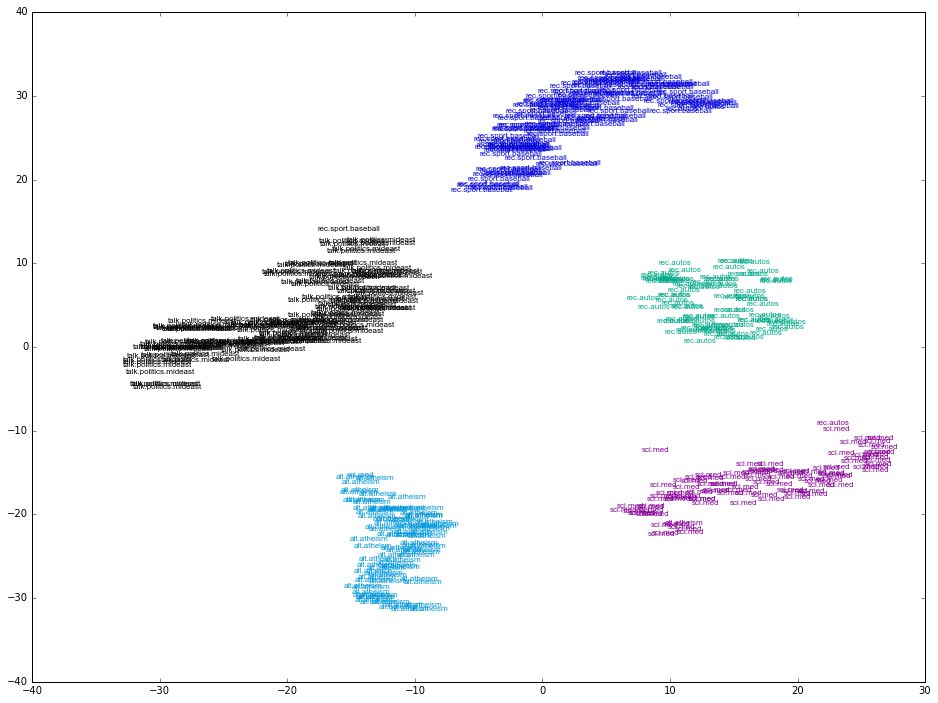

In [133]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax1 = plt.subplots(figsize=(16, 12))  
test_classes = label_encoder.inverse_transform(Y_test.argmax(axis=1))

# first plot slices:
x1, x2 = coor[:,0], coor[:,1]
ax1.scatter(x1, x2, 100, edgecolors='none', facecolors='none')

from sklearn.cluster import AgglomerativeClustering

# clustering on top (add some colouring):
clustering = AgglomerativeClustering(linkage='ward',
                                    affinity='euclidean', n_clusters=5)
clustering.fit(coor)

# add names:
for x, y, name, cluster_label in zip(x1, x2, test_classes, clustering.labels_):
    ax1.text(x, y, name, ha='center', va="center",
            color=plt.cm.spectral(cluster_label / 10.),
            fontdict={'family': 'Arial', 'size': 8})
plt.show()

Visualizing such representations are a great way to visually inspect and intuitively evaluate your work.

## A POS-tagger using (only!) embeddings

In [427]:
#CoNLL-2000 shared task

def load_data(path):
    data = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = line.strip()
        if line:
            try:
                token, pos, _ = line.strip().split()
                data.append((token, pos))
            except:
                pass
    return data

        
train_data = load_data('data/pos/train.txt')
test_data = load_data('data/pos/test.txt')

print(len(train_data))
for i in train_data[:10]:
    print(' - '.join(i))

211727
Confidence - NN
in - IN
the - DT
pound - NN
is - VBZ
widely - RB
expected - VBN
to - TO
take - VB
another - DT


In [428]:
train_tokens, train_pos = zip(*train_data)
test_tokens, test_pos = zip(*test_data)

In [429]:
tag_encoder = LabelEncoder()
tag_encoder.fit(train_pos + test_pos)
print('Total nb tags:', len(tag_encoder.classes_))

train_y = tag_encoder.transform(train_pos)
test_y = tag_encoder.transform(test_pos)

Y_train = np_utils.to_categorical(train_y,
                                  nb_classes=len(tag_encoder.classes_))
Y_test = np_utils.to_categorical(test_y,
                                 nb_classes=len(tag_encoder.classes_))


Total nb tags: 44


In [430]:
from collections import Counter
vocab = Counter(train_tokens)
indexer = {'unk': 0}

#max_vocab_size = 2000
for k, v in vocab.most_common():
    indexer[k] = len(indexer)

In [438]:
nb_left, nb_right = 2, 1

def vectorize(tokens):
    sequences = []
    for curr_idx, token in enumerate(tokens):
        #print(curr_idx)
        #cnt += 1
        #if cnt >= 20:
        #    break

        left_context = tokens[(curr_idx - 2) : curr_idx]
        while len(left_context) < nb_left:
            left_context = ['<unk>'] + left_context

        right_context = tokens[curr_idx + 1 : curr_idx + 2]
        while len(right_context) < nb_right:
            right_context += ['<unk>']

        seq = left_context + [token] + right_context

        ints = [indexer[t] if t in indexer else 0 for t in seq]

        sequences.append(ints)
    
    return np.array(sequences, dtype='int8')

train_X = vectorize(list(train_tokens))
test_X = vectorize(list(test_tokens))

In [453]:
from keras.layers import Embedding, Dense, Activation, Flatten, Dropout

from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(input_dim=len(indexer), output_dim=150,
                    input_length=nb_left + 1 + nb_right))
model.add(LSTM(100, return_sequences=False, activation='tanh'))
model.add(Flatten())
model.add(Activation('relu'))
model.add(Dense(len(tag_encoder.classes_)))
model.add(Activation('softmax'))

In [454]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [455]:
model.fit(train_X, Y_train, batch_size=100, nb_epoch=10,
          shuffle=True, validation_data=(test_X, Y_test))

INFO (theano.gof.compilelock): Refreshing lock /Users/mike/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


Train on 211727 samples, validate on 47377 samples
Epoch 1/10
211727/211727 [==============================] - 112s - loss: 1.6716 - acc: 0.5248 - val_loss: 1.2045 - val_acc: 0.6475
Epoch 2/10
211727/211727 [==============================] - 114s - loss: 1.1178 - acc: 0.6759 - val_loss: 1.0609 - val_acc: 0.6832
Epoch 3/10
211727/211727 [==============================] - 116s - loss: 1.0103 - acc: 0.7007 - val_loss: 1.0057 - val_acc: 0.6966
Epoch 4/10
174200/211727 [=======================>......] - ETA: 19s - loss: 0.9511 - acc: 0.7156

KeyboardInterrupt: 

In [402]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_25 (Embedding)           (None, 4, 300)      5736900     embedding_input_25[0][0]         
____________________________________________________________________________________________________
flatten_22 (Flatten)               (None, 1200)        0           embedding_25[0][0]               
____________________________________________________________________________________________________
activation_41 (Activation)         (None, 1200)        0           flatten_22[0][0]                 
____________________________________________________________________________________________________
dense_47 (Dense)                   (None, 300)         360300      activation_41[0][0]              
___________________________________________________________________________________________

(19123, 150)
(300, 150)


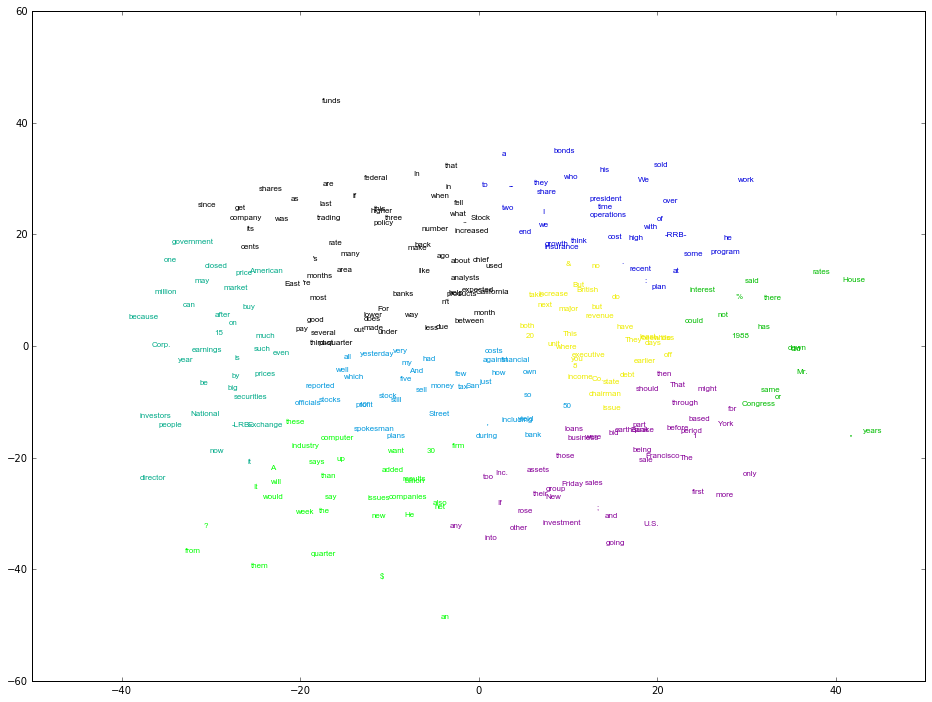

In [437]:
all_weights = model.layers[0].get_weights()[0]
print(all_weights.shape)

mfi = [k for k, _ in vocab.most_common(300)]
word_labels, embeddings = [], []
for w, k in indexer.items():
    if w in mfi:
        word_labels.append(w)
        embeddings.append(all_weights[k])

embeddings = np.array(embeddings, dtype='float32')
print(embeddings.shape)

#norm_weights = np_utils.normalize(embeddings)

tsne = TSNE(n_components=2)
coor = tsne.fit_transform(embeddings)

fig, ax1 = plt.subplots(figsize=(16, 12))

# first plot slices:
x1, x2 = coor[:,0], coor[:,1]
ax1.scatter(x1, x2, 100, edgecolors='none', facecolors='none')

# clustering on top (add some colouring):
clustering = AgglomerativeClustering(linkage='ward',
                                    affinity='euclidean', n_clusters=8)
clustering.fit(coor)

# add names:
for x, y, name, cluster_label in zip(x1, x2, word_labels, clustering.labels_):
    ax1.text(x, y, name, ha='center', va="center",
            color=plt.cm.spectral(cluster_label / 10.),
            fontdict={'family': 'Arial', 'size': 8})
plt.show()